# Fine-Tuning BERT
BERT est un cadre en deux étapes. La première étape est le pré-entraînement, et la seconde est le réglage fin, comme le montre la figure.


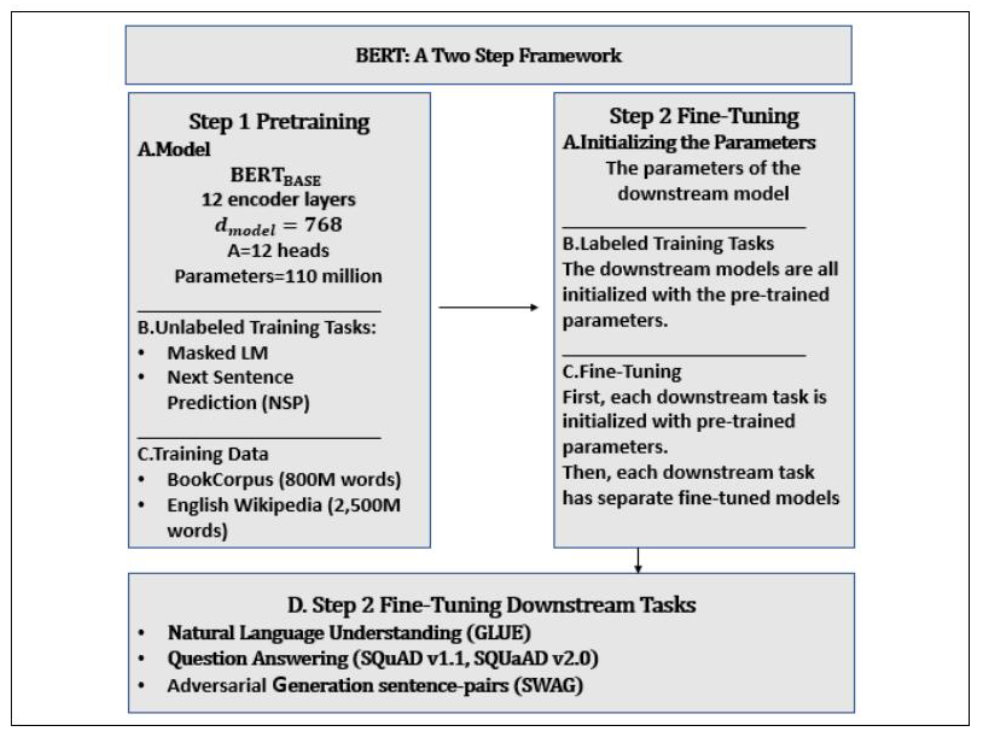


La formation d'un modèle de transformateur peut prendre des heures, voire des jours. Il faut un certain temps pour concevoir l'architecture et les paramètres, et sélectionner les ensembles de données appropriés pour former un mode transformateur.

La pré-formation est la première étape du framework BERT qui peut être décomposée en deux sous-étapes :

* Dénir l'architecture du modèle : nombre de couches, nombre de têtes, dimensions, et les autres briques du modèle

* Former les modèle sur la modélisation du langage masqué (MLM) et les tâches NSP

La deuxième étape du cadre BERT est le réglage fin, qui peut également être décomposé en deux sous-étapes :
* Initialisation du modèle en aval choisi avec les paramètres entraînés du modèle BERT pré-entraîné

* Réglage fin des paramètres pour des les tâches en aval telles que la reconnaissance de l'implication textuelle (RTE), la réponse aux questions (SQuAD v1.1, SQuAD v2.0) et les situations avec des générations contradictoires (SWAG)

Dans cette section, nous avons couvert les informations dont nous avons besoin pour affiner un modèle BERT. 


Dans ce guide, le modèle BERT que nous allons affiner sera formé sur le Corpus of Linguistic Acceptability (CoLA). La tâche en aval est basée sur les jugements d'acceptabilité des réseaux neuronaux par Alex Warstadt, Amanpreet Singh et Samuel R. Bowman.


Nous allons affiner un modèle BERT qui déterminera l'acceptabilité grammaticale d'une phrase. Le modèle fne-tuned aura acquis un certain niveau de compétence linguistique.

Nous sommes passés par l'architecture BERT et son cadre de préformation et de fine-tuning. Optimisons maintenant un modèle BERT

## Fine-tuning BERT

Dans cette section, nous allons affiner un modèle BERT pour prédire la tâche en aval des jugements d'acceptabilité et mesurer les prédictions avec le coefficient de corrélation de Matthews (MCC), qui sera expliqué dans la section Évaluation à l'aide du coefficient de corrélation de Matthews.

## Installation de pakage Hugging Face PyTorch pour BERT

Hugging Face fournit un modèle BERT pré-entraîné. Hugging Face a développé une classe de base nommée PreTrainedModel. En installant cette classe, nous pouvons charger un modèle à partir d'une configuration de modèle pré-entraînée.

Hugging Face fournit des modules dans TensorFlow et PyTorch. Je recommande qu'un développeur se sente à l'aise avec les deux environnements. D'excellentes équipes de recherche en IA utilisent l'un ou les deux environnements. 

Dans ce guide, nous installerons les modules requis comme suit :

In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 56 kB 3.2 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 3.3 MB 22.3 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 


The installation will run, or requirement satised messages will be displayed.We can now import the modules needed for the program

## Importation des modules


Nous importerons les modules pré-entraînés requis, tels que le tokenizer BERT pré-entraîné et la configuration du modèle BERT. L'optimiseur BERTAdam est importé avec le module de classification des séquences

In [26]:

#@title Importing the modules
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Aucun message ne s'affichera si tout se passe bien, sachant que Google Colab a pré-installé les modules sur la VM que nous utilisons

## Spécification de CUDA comme périphérique pour torch

Nous allons maintenant préciser que torch utilise la Compute United Device Architecture (CUDA) pour mettre la puissance de calcul parallèle de la carte NVIDIA au service de notre modèle d'attention multi-têtes.



In [3]:
#@title Specifying CUDA as the device for Torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Chargement du jeu de données

Nous allons maintenant charger le CoLA basé sur le Warstadt et al. (2018) paper.

General Language Understanding Evaluation (GLUE) considère l'acceptabilité linguistique comme une tâche PNL de première priorité

Nous utiliserons le package wget pour télécharger l'ensemble de données dans le système de fichiers de l'instance Colab


In [6]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=0b16602223bc2b07dc4a03ea628c53c7b0829270f912704674585db554f43bd3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [8]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Décompressez l'ensemble de données dans le système de fichiers. Vous pouvez parcourir le système de fichiers de l'instance Colab dans la barre latérale de gauche.

In [9]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


Nous pouvons voir à partir des noms de fichiers que des versions tokenisées et brutes des données sont disponibles.

Nous ne pouvons pas utiliser la version pré-tokenisée car, pour appliquer le BERT pré-entraîné, nous devons utiliser le tokenizer fourni par le modèle. En effet, (1) le modèle a un vocabulaire spécifique et fixe et (2) le tokenizer BERT a une manière particulière de gérer les mots hors vocabulaire.

Nous utiliserons des pandas pour analyser l'ensemble d'apprentissage "dans le domaine" et examiner quelques-unes de ses propriétés et points de données.

In [11]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

Un échantillon de 10 lignes s'affiche pour visualiser la tâche de jugement d'acceptabilité et voir si une séquence a du sens ou non 

In [12]:
df.sample(10)

,sentence_source,label,label_notes,sentence
2864,l-93,1,NaN,Carol carved the marble.
3811,ks08,0,*,To delay the march and to go ahead with it has...
461,bc01,1,NaN,The boat was sunk to collect the insurance.
8108,ad03,0,*,Which poem did you hear Homer's recital of las...
4286,ks08,0,*,That he is clever is eager to be obvious.
7619,sks13,1,NaN,There were several doctors available.
5572,c_13,1,NaN,Sally kissed herself.
2390,l-93,0,*,The captain named the ship as Seafarer.
2691,l-93,1,NaN,Amanda carried the package to New York.
2540,l-93,1,NaN,I put books on the table.


Les deux propriétés qui nous intéressent réellement sont la phrase et son étiquette, appelée « jugement d'acceptabilité » (0=inacceptable, 1=acceptable).

Voici cinq phrases qui sont étiquetées comme non grammaticalement acceptables. Notez à quel point cette tâche est plus difficile que quelque chose comme l'analyse des sentiments !

In [13]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
8452,The pig grunt,0
2829,Paula's right hand spanked the naughty child.,0
7601,She slept the picture of Bill.,0
3894,John stayed him busy.,0
7818,I believed she is pregnant,0


## Créer des listes de phrases et  d'étiquettes et ajouter des jetons BERT

Extrayons les phrases et les étiquettes de notre ensemble d'entraînement sous forme de numpy ndarrays

In [18]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values
labels = df.label.values

## BERT Tokenizer

Pour alimenter notre texte à BERT, il doit être divisé en jetons, puis ces jetons doivent être mappés sur leur index dans le vocabulaire du tokenizer.

La tokenisation doit être effectuée par le tokenizer inclus avec BERT - la cellule ci-dessous le téléchargera pour nous.

In [20]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Appliquons le tokenizer à une phrase juste pour voir le résultat.

In [21]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Lorsque nous convertissons réellement toutes nos phrases, nous utiliserons la fonction tokenize.encode pour gérer les deux étapes, plutôt que d'appeler tokenize et convert_tokens_to_ids séparément.

Avant de pouvoir le faire, cependant, nous devons parler de certaines des exigences de formatage du BERT

## Formatage requis

Le code ci-dessus a omis quelques étapes de formatage requises que nous examinerons ici.

Note latérale : Le format d'entrée de BERT me semble « sur-spécifié »… Nous sommes tenus de lui donner un certain nombre d'informations qui semblent redondantes, ou comme elles pourraient facilement être déduites des données sans que nous les fournissions explicitement. Mais c'est ce que c'est, et je pense que cela aura plus de sens une fois que j'aurai une compréhension plus approfondie des éléments internes du BERT.

Nous sommes tenus de :

* Ajoutez des jetons spéciaux au début et à la fin de chaque phrase.
* Complétez et tronquez toutes les phrases à une seule longueur constante.
* Différenciez explicitement les jetons réels des jetons de remplissage avec le « masque d'attention »

**Jetons spéciaux**

[SEP]

À la fin de chaque phrase, nous devons ajouter le jeton spécial [SEP].

Ce jeton est un artefact de tâches à deux phrases, où BERT reçoit deux phrases distinctes et est invité à déterminer quelque chose (par exemple, la réponse à la question de la phrase A peut-elle être trouvée dans la phrase B ?).

Je ne sais pas encore pourquoi le jeton est toujours requis lorsque nous n'avons qu'une entrée à une seule phrase, mais c'est le cas !

[CLS]

Pour les tâches de classification, nous devons ajouter le jeton spécial [CLS] au début de chaque phrase.

Ce jeton a une signification particulière. BERT se compose de 12 couches de transformateur. Chaque transformateur prend une liste d'embedding de jetons et produit le même nombre d'incorporations sur la sortie (mais avec les valeurs de caractéristique modifiées, bien sûr !).

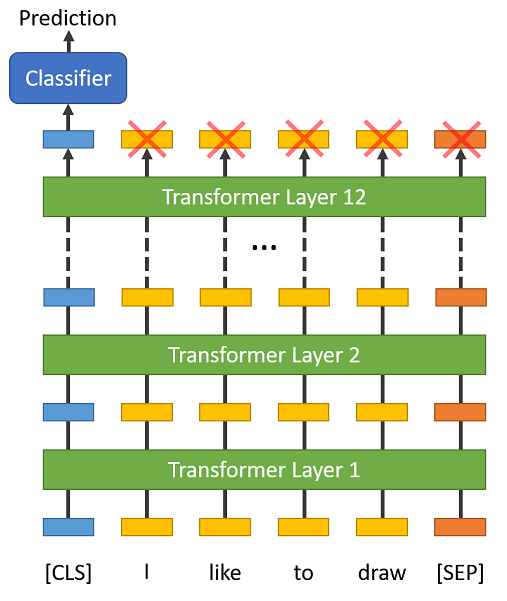

En sortie du dernier (12e) transformateur, seul le premier plongement (correspondant au jeton [CLS]) est utilisé par le classifieur.

« Le premier jeton de chaque séquence est toujours un jeton de classification spéciale ([CLS]). L'état caché final correspondant à ce jeton est utilisé comme représentation de séquence agrégée pour les tâches de classification. (extrait de l'article du BERT)

Vous pourriez penser à essayer une stratégie de mise en commun sur les inclusions finales, mais ce n'est pas nécessaire. Étant donné que BERT est entraîné à utiliser uniquement ce jeton [CLS] pour la classification, nous savons que le modèle a été motivé pour coder tout ce dont il a besoin pour l'étape de classification dans ce vecteur d'intégration unique de 768 valeurs. C'est déjà fait la mutualisation pour nous !


**Sentence Length & Attention Mask**


Les phrases de notre ensemble de données ont évidemment des longueurs variables, alors comment BERT gère-t-il cela ?

BERT a deux contraintes :

Toutes les phrases doivent être complétées ou tronquées à une seule longueur fixe.


La longueur maximale de la phrase est de 512 jetons.


Le remplissage est effectué avec un jeton spécial [PAD], qui est à l'index 0 dans le vocabulaire BERT. 


L'illustration ci-dessous montre le remplissage jusqu'à un « MAX_LEN » de 8 jetons.

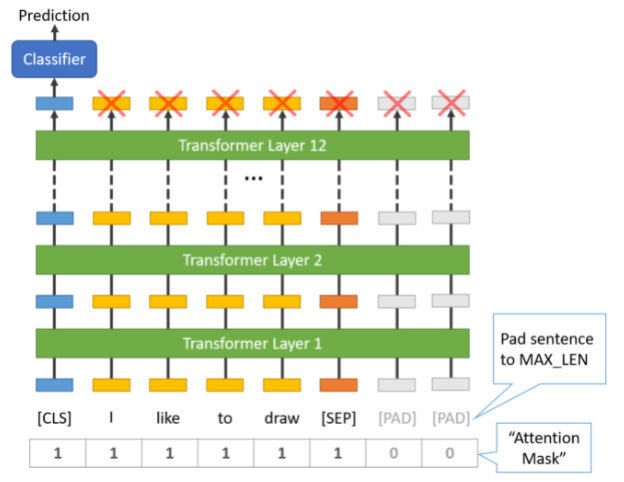

Le « Attention Mask » est simplement un tableau de 1 et de 0 indiquant quels jetons remplissent et lesquels ne le sont pas (cela semble un peu redondant, n'est-ce pas ?!). 

Ce masque indique au mécanisme « Self-Attention » dans BERT de ne pas incorporer ces jetons PAD dans son interprétation de la phrase.

Cependant,  maximum length a un impact sur la vitesse d'entraînement et d'évaluation. Par exemple, avec une Tesla K80 :

MAX_LEN = 128 --> Training epochs take ~5:28 each

MAX_LEN = 64 --> Training epochs take ~2:57 each

## Tokenize Dataset


La bibliothèque Transformers fournit une fonction d'encodage utile qui gérera la plupart des étapes d'analyse et de préparation des données pour nous.

Avant que nous soyons prêts à encoder notre texte, cependant, nous devons décider d'une longueur de phrase maximale pour le remplissage / la troncature.

La cellule ci-dessous effectuera une passe de tokenisation de l'ensemble de données afin de mesurer la longueur maximale de la phrase

In [22]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


Juste au cas où il y aurait des phrases de test plus longues, je définirai la longueur maximale à 64.

Nous sommes maintenant prêts à effectuer la véritable tokenisation.

La fonction tokenizer.encode_plus combine pour nous plusieurs étapes :

* 1. Divisez la phrase en jetons.
* 2. Ajoutez les jetons spéciaux [CLS] et [SEP].
* 3. Mappez les jetons sur leurs identifiants.
* 4. Complétez ou tronquez toutes les phrases à la même longueur.
* 5. Créez les masques d'attention qui différencient explicitement les jetons réels des jetons [PAD].


Les quatre premières fonctionnalités sont dans tokenizer.encode, mais j'utilise tokenizer.encode_plus pour obtenir le cinquième élément (masques d'attention).

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Training & Validation Split

Divisez notre ensemble de formation pour utiliser 90 % pour la formation et 10 % pour la validation

In [27]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


## Sélection d'une taille de lot et création d'un itérateur

Nous allons également créer un itérateur pour notre ensemble de données à l'aide de la classe torche DataLoader. Cela permet d'économiser de la mémoire pendant l'entraînement car, contrairement à une boucle for, avec un itérateur, l'ensemble de données n'a pas besoin d'être chargé en mémoire

In [28]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## BERT model configuration


In [29]:
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## BertForSequenceClassification

Pour cette tâche, nous voulons d'abord modifier le modèle BERT pré-entraîné pour donner des sorties pour la classification, puis nous voulons continuer à entraîner le modèle sur notre ensemble de données jusqu'à ce que l'ensemble du modèle, de bout en bout, soit bien adapté pour notre tâche.

Heureusement, l'implémentation huggingface pytorch comprend un ensemble d'interfaces conçues pour une variété de tâches NLP. Bien que ces interfaces soient toutes construites sur un modèle BERT entraîné, chacune a des couches supérieures et des types de sortie différents conçus pour s'adapter à leur tâche NLP spécifique.

Voici la liste actuelle des classes fournies pour le réglage :

* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification - Celui que nous utiliserons..
* BertForTokenClassification
* BertForQuestionAnswering



La documentation pour ceux-ci peut être trouvée ici. https://huggingface.co/transformers/v2.2.0/model_doc/bert.html

Nous utiliserons BertForSequenceClassification. Il s'agit du modèle BERT normal avec une seule couche linéaire ajoutée au-dessus pour la classification que nous utiliserons comme classificateur de phrases. Au fur et à mesure que nous alimentons les données d'entrée, l'ensemble du modèle BERT pré-entraîné et la couche de classification supplémentaire non entraînée sont entraînés à notre tâche spécifique.

OK, chargeons BERT ! Il existe différents modèles BERT pré-entraînés disponibles. "bert-base-uncased" désigne la version qui n'a que des lettres minuscules ("uncased") et est la version la plus petite des deux ("base" vs "large").

La documentation de from_pretrained peut être trouvée ici, avec les paramètres supplémentaires définis ici. https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained

In [30]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Juste par curiosité, nous pouvons parcourir tous les paramètres du modèle par nom ici.

Dans la cellule ci-dessous, j'ai imprimé les noms et les dimensions des poids pour :

The embedding layer.
The first of the twelve transformers.
The output layer..

In [31]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer & Learning Rate Scheduler

Maintenant que notre modèle est chargé, nous devons récupérer les hyperparamètres d'entraînement à partir du modèle stocké.

À des fins d'ajustement, les auteurs recommandent de choisir parmi les valeurs suivantes (de l'annexe A.3 de l'article BERT) :

* Taille du lot : 16, 32
* Taux d'apprentissage (Adam): 5e-5, 3e-5, 2e-5
* Nombre d'époques : 2, 3, 4

Nous avons choisi:

* Taille du lot : 32 (défini lors de la création de nos DataLoaders)
* Taux d'apprentissage : 2e-5
* Époques : 4 (on verra que c'est probablement trop…)

Le paramètre epsilon eps = 1e-8 est « un très petit nombre pour éviter toute division par zéro dans l'implémentation » (à partir d'ici). https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

Vous pouvez retrouver la création de l'optimiseur AdamW dans run_glue.py ici https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [33]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Vous trouverez ci-dessous notre boucle d'entraînement. Il se passe beaucoup de choses, mais fondamentalement, pour chaque passage de notre boucle, nous avons une phase de test et une phase de validation.

Merci à Stas Bekman d'avoir fourni les informations et le code permettant d'utiliser la perte de validation pour détecter le surajustement !

Entraînement:

* Déballez nos entrées de données et nos étiquettes
* Charger les données sur le GPU pour l'accélération
* Effacez les gradients calculés lors de la passe précédente.
* Dans pytorch, les dégradés s'accumulent par défaut (utile pour des choses comme les RNN) à moins que vous ne les effaciez explicitement.
* Passe avant (transmettre les données d'entrée via le réseau)
* Passe arrière (rétropropagation)
* Dites au réseau de mettre à jour les paramètres avec Optimizer.step()
* Suivre les variables pour surveiller les progrès


Évaluation :

* Déballez nos entrées de données et nos étiquettes
* Charger les données sur le GPU pour l'accélération
* Passe avant (transmettre les données d'entrée via le réseau)
* Calculez les pertes sur nos données de validation et suivez les variables pour suivre les progrès


Pytorch nous cache tous les calculs détaillés, mais nous avons commenté le code pour indiquer lesquelles des étapes ci-dessus se produisent sur chaque ligne.

PyTorch propose également des tutorials pour débutants qui peuvent également vous être utiles. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Définir une fonction d'assistance pour le calcul de la précision.

In [34]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Fonction d'assistance pour formater les temps écoulés en hh:mm:ss

In [35]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Nous sommes prêts à lancer la formation !

In [38]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs['loss']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            

            
        # Accumulate the validation loss.
        loss = outputs['loss']
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:56.
  Batch   120  of    241.    Elapsed: 0:01:24.
  Batch   160  of    241.    Elapsed: 0:01:52.
  Batch   200  of    241.    Elapsed: 0:02:20.
  Batch   240  of    241.    Elapsed: 0:02:48.

  Average training loss: 0.21
  Training epcoh took: 0:02:48

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.60
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:56.
  Batch   120  of    241.    Elapsed: 0:01:24.
  Batch   160  of    241.    Elapsed: 0:01:51.
  Batch   200  of    241.    Elapsed: 0:02:19.
  Batch   240  of    241.    Elapsed: 0:02:47.

  Average training loss: 0.20
  Training epcoh took: 0:02:48

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.46
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

Regardons le résumé du processus de formation

In [39]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.21,0.60,0.85,0:02:48,0:00:06
2,0.20,0.46,0.85,0:02:48,0:00:06
3,0.14,0.51,0.86,0:02:48,0:00:06
4,0.12,0.51,0.86,0:02:48,0:00:06


Notez que, tandis que la perte d'entraînement diminue à chaque époque, la perte de validation augmente ! Cela suggère que nous entraînons notre modèle trop longtemps et qu'il sur-ajuste les données d'entraînement.

(Pour référence, nous utilisons 7 695 échantillons d'apprentissage et 856 échantillons de validation).

La perte de validation est une mesure plus précise que la précision, car avec la précision, nous ne nous soucions pas de la valeur de sortie exacte, mais uniquement de quel côté d'un seuil elle tombe.

Si nous prédisons la bonne réponse, mais avec moins de confiance, alors la perte de validation l'attrapera, contrairement à la précision.

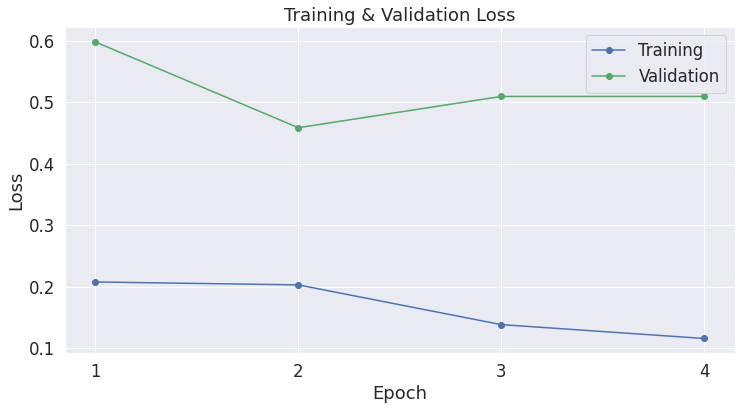

In [40]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance On Test Set

Maintenant, nous allons charger l'ensemble de données à retenir et préparer les entrées comme nous l'avons fait avec l'ensemble d'apprentissage. Ensuite, nous évaluerons les prédictions à l'aide du coefficient de corrélation de Matthew, car il s'agit de la métrique utilisée par la communauté NLP au sens large pour évaluer les performances sur CoLA. Avec cette métrique, +1 est le meilleur score et -1 est le pire score. De cette façon, nous pouvons voir nos performances par rapport aux modèles de pointe pour cette tâche spécifique.


### Préparation des données
Nous devrons appliquer toutes les mêmes étapes que nous avons suivies pour les données d'entraînement afin de préparer notre ensemble de données de test.

In [41]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

Number of test sentences: 516



In [42]:
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Évaluer sur l'ensemble de test

Une fois l'ensemble de test préparé, nous pouvons appliquer notre modèle affiné pour générer des prédictions sur l'ensemble de test.

In [43]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


La précision du benchmark CoLA est mesurée à l'aide du « coefficient de corrélation de Matthews » (MCC).

Nous utilisons MCC ici car les classes sont déséquilibrées.


Le coefficient de corrélation de Matthews (MCC) a été initialement conçu pour mesurer la qualité des classifications binaires et peut être modifié pour devenir un coefficient de corrélation multi-classes. Une classification à deux classes peut être faite avec quatre probabilités à chaque prédiction.

* TP = True Positive
* TN = True Negative
* FP = False Positive
* FN = False Negative

Brian W. Matthews, un biochimiste, l'a conçu en 1975, inspiré par la fonction phi de ses prédécesseurs. Depuis lors, il a évolué dans divers formats tels que le suivant

$$MCC = \frac{TPxTN-FPxFN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$


La valeur produite par MCC est comprise entre -1 et +1. +1 est la valeur positive maximale d'une prédiction. -1 est une prédiction inverse. 0 est une prédiction aléatoire moyenne

In [44]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [45]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


Le score final sera basé sur l'ensemble du test, mais examinons les scores des lots individuels pour avoir une idée de la variabilité de la métrique entre les lots.

Chaque lot contient 32 phrases, à l'exception du dernier lot qui ne contient que (516 % 32) = 4 phrases de test

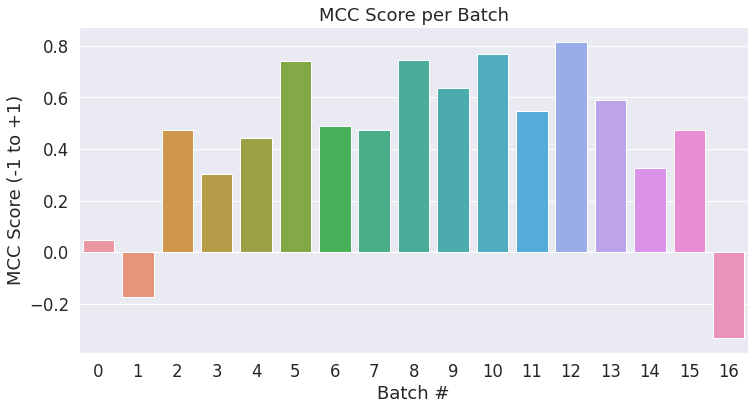

In [46]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Nous allons maintenant combiner les résultats de tous les lots et calculer notre score MCC final.

In [47]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.493


En une demi-heure environ et sans aucun réglage d'hyperparamètres (ajustement du taux d'apprentissage, des époques, de la taille du lot, des propriétés ADAM, etc.), nous sommes en mesure d'obtenir un bon score.

Remarque : Pour maximiser le score, nous devons supprimer l'« ensemble de validation » (que nous avons utilisé pour déterminer le nombre d'époques pour lesquelles s'entraîner) et nous entraîner sur l'ensemble de l'ensemble d'entraînement.

La bibliothèque documente ici la précision attendue pour cette référence comme 49.23.
https://huggingface.co/transformers/examples.html#glue

Vous pouvez également consulter le classement officiel ici.

https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy

Notez que (en raison de la petite taille de l'ensemble de données ?) La précision peut varier considérablement d'une exécution à l'autre.